In [58]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import cohen_kappa_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.backend import batch_set_value

In [6]:
loaded_images = np.load('images.npy')
train = pd.read_csv('N:/Z Project 5/aptos2019-blindness-detection/train.csv')

X = loaded_images
y = train['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

y_train = utils.to_categorical(y_train, 5)
y_test = utils.to_categorical(y_test, 5)

In [47]:
#First Attempt 1 CNN
cnn = Sequential()
cnn.add(Conv2D(filters=10, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
cnn.add(MaxPooling2D(pool_size=(3,3)))
cnn.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(3,3)))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu')) #hidden layer 128 node
cnn.add(Dense(32, activation='relu')) #hidden layer 32 node
cnn.add(Dense(5, activation='softmax')) #use 10 for 0-9 digits and softmax because its a multiple classification problem
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=256, epochs=10, verbose=1)

Epoch 1/10
11/11 [==============================] - 15s 1s/step - loss: 1.2413 - accuracy: 0.4873 - val_loss: 1.0078 - val_accuracy: 0.6856
Epoch 2/10
11/11 [==============================] - 14s 1s/step - loss: 0.9080 - accuracy: 0.6773 - val_loss: 0.8738 - val_accuracy: 0.6965
Epoch 3/10
11/11 [==============================] - 15s 1s/step - loss: 0.8164 - accuracy: 0.7007 - val_loss: 0.8212 - val_accuracy: 0.7041
Epoch 4/10
11/11 [==============================] - 15s 1s/step - loss: 0.7726 - accuracy: 0.7265 - val_loss: 0.8134 - val_accuracy: 0.7074
Epoch 5/10
11/11 [==============================] - 14s 1s/step - loss: 0.7471 - accuracy: 0.7243 - val_loss: 0.7834 - val_accuracy: 0.7172
Epoch 6/10
11/11 [==============================] - 15s 1s/step - loss: 0.7332 - accuracy: 0.7385 - val_loss: 0.7619 - val_accuracy: 0.7238
Epoch 7/10
11/11 [==============================] - 14s 1s/step - loss: 0.7034 - accuracy: 0.7422 - val_loss: 0.7578 - val_accuracy: 0.7238
Epoch 8/10
11/11 [==

In [48]:
# # Calculate QWK on train set
train_preds = np.argmax(cnn.predict(X_train), axis=1)
train_score = cohen_kappa_score(np.argmax(y_train,axis=1), train_preds, weights="quadratic")

# Calculate QWK on test set
test_preds = np.argmax(cnn.predict(X_test), axis=1)
test_score = cohen_kappa_score(np.argmax(y_test,axis=1), test_preds, weights="quadratic")

In [49]:
print(cnn.evaluate(X_test, y_test, verbose=1))
print(f'Training QWK: {train_score}')
print(f'Testing QWK: {test_score}')

29/29 [==============================] - 1s 32ms/step - loss: 0.7605 - accuracy: 0.7249
[0.7605442404747009, 0.7248908281326294]
Training QWK: 0.7397767338971024
Testing QWK: 0.7043214489434051


**Training accuracy of .76 and testing of .724, not bad for my first shot in the dark model. Okay testing accuracy and not very overfit. QWK of .704 leaves a lot to be desired though. Lets gridesearch to try and further tune the hyperparameters**

In [44]:
#gridsearch 1 CNN
def cnn_func(filters = 10, kernel_1 = (5,5), pool_1=(3,3), kernel_2=(5,5), pool_2=(3,3), dense_layer_one_neurons=8, dense_layer_two_neurons=8):
    cnn = Sequential()
    cnn.add(Conv2D(filters=filters, kernel_size=kernel_1, activation='relu', input_shape=(128,128,3)))
    cnn.add(MaxPooling2D(pool_size=pool_1))
    cnn.add(Conv2D(16, kernel_size=kernel_2, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=pool_2))
    cnn.add(Flatten())
    cnn.add(Dense(dense_layer_one_neurons, activation='relu')) #hidden layer 128 node
    cnn.add(Dense(dense_layer_two_neurons, activation='relu')) #hidden layer 32 node
    cnn.add(Dense(5, activation='softmax')) #use 10 for 0-9 digits and softmax because its a multiple classification problem
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn

nn = KerasClassifier(build_fn=cnn_func, batch_size=512, epochs=10, verbose=1)

params = {'filters':[5, 10, 15, 20],
         'kernel_1':[(4,4), (5,5), (6,6)],
         'pool_1':[(3,3), (4,4), (5,5)],
         'kernel_2':[(4,4), (5,5), (6,6)],
         'pool_2':[(3,3), (4,4), (5,5)],
         'dense_layer_one_neurons': [32, 48, 64, 84, 128, 256],
         'dense_layer_two_neurons': [8, 16, 32, 48, 64],
         'batch_size': [128, 256, 512],
         'epochs': [10, 15, 20]}

grid = RandomizedSearchCV(nn, params, cv=3, n_iter=100, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)

best params: {'pool_2': (5, 5), 'pool_1': (5, 5),
'kernel_2': (6, 6), 'kernel_1': (5, 5), 'filters': 15,
'epochs': 20, 'dense_layer_two_neurons': 64,
'dense_layer_one_neurons': 256, 'batch_size': 128}


In [52]:
#grid 1 best params CNN
cnn1 = Sequential()
cnn1.add(Conv2D(filters=15, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
cnn1.add(MaxPooling2D(pool_size=(5,5)))
cnn1.add(Conv2D(16, kernel_size=(6,6), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(5,5)))
cnn1.add(Flatten())
cnn1.add(Dense(256, activation='relu')) #hidden layer 128 node
cnn1.add(Dense(64, activation='relu')) #hidden layer 32 node
cnn1.add(Dense(5, activation='softmax')) #use 10 for 0-9 digits and softmax because its a multiple classification problem
cnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = cnn1.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
22/22 [==============================] - 15s 668ms/step - loss: 1.2517 - accuracy: 0.5015 - val_loss: 1.0597 - val_accuracy: 0.6561
Epoch 2/20
22/22 [==============================] - 14s 655ms/step - loss: 0.9399 - accuracy: 0.6730 - val_loss: 0.8869 - val_accuracy: 0.6747
Epoch 3/20
22/22 [==============================] - 14s 650ms/step - loss: 0.8347 - accuracy: 0.6992 - val_loss: 0.8116 - val_accuracy: 0.7074
Epoch 4/20
22/22 [==============================] - 14s 661ms/step - loss: 0.7759 - accuracy: 0.7130 - val_loss: 0.8166 - val_accuracy: 0.7074
Epoch 5/20
22/22 [==============================] - 15s 667ms/step - loss: 0.7324 - accuracy: 0.7334 - val_loss: 0.7717 - val_accuracy: 0.7271
Epoch 6/20
22/22 [==============================] - 14s 655ms/step - loss: 0.7103 - accuracy: 0.7382 - val_loss: 0.7573 - val_accuracy: 0.7238
Epoch 7/20
22/22 [==============================] - 14s 649ms/step - loss: 0.7124 - accuracy: 0.7480 - val_loss: 0.7829 - val_accuracy: 0.7303

In [53]:
# # Calculate QWK on train set
train_preds = np.argmax(cnn1.predict(X_train), axis=1)
train_score = cohen_kappa_score(np.argmax(y_train,axis=1), train_preds, weights="quadratic")

# Calculate QWK on test set
test_preds = np.argmax(cnn1.predict(X_test), axis=1)
test_score = cohen_kappa_score(np.argmax(y_test,axis=1), test_preds, weights="quadratic")

In [54]:
print(cnn1.evaluate(X_test, y_test, verbose=1))
print(f'Training QWK: {train_score}')
print(f'Testing QWK: {test_score}')

29/29 [==============================] - 1s 32ms/step - loss: 0.8279 - accuracy: 0.6932
[0.8278561234474182, 0.693231463432312]
Training QWK: 0.7661349116213768
Testing QWK: 0.6871388441619093


**Training accuracy of .82 and testing of .6932, I managed to way increase my overfitness and actually decrease my testing accuracy and it took several hours to gridsearch. My QWK also decreased to a measely .687. This model is worse than my first attempt in every way. I'm going to try a different gridsearch.**

In [45]:
gridsearch 2 CNN
def cnn2_func(filter_1 = 15, filter_2=15, kernel_1 = (5,5), pool_1=(5,5), kernel_2=(6,6), pool_2=(5,5),
            dense_layer_one_neurons=256, dense_layer_two_neurons=64):
    cnn = Sequential()
    cnn.add(Conv2D(filters=filter_1, kernel_size=kernel_1, activation='relu', input_shape=(120,160,3)))
    cnn.add(MaxPooling2D(pool_size=pool_1))
    cnn.add(Conv2D(filters=filter_2, kernel_size=kernel_2, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=pool_2))
    cnn.add(Flatten())
    cnn.add(Dense(dense_layer_one_neurons, activation='relu')) #hidden layer 128 node
    cnn.add(Dense(dense_layer_two_neurons, activation='relu')) #hidden layer 32 node
    cnn.add(Dense(5, activation='softmax')) #use 10 for 0-9 digits and softmax because its a multiple classification problem

    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

nn2 = KerasClassifier(build_fn=cnn2_func, batch_size=128, verbose=1)

params = {'pool_1':[(5,5), (6,6), (7,7)],
         'filter_2':[10, 15, 20],
         'kernel_2':[(6,6), (7,7), (8,8)],
         'pool_2':[(5,5), (6,6), (7,7)],
         'dense_layer_one_neurons': [256, 512],
         'dense_layer_two_neurons': [64, 128, 256, 512],
         'epochs': [20, 25, 30]}

grid2 = RandomizedSearchCV(nn2, params, cv=3, n_iter=100, verbose=1)
grid2.fit(X_train, y_train)

print(grid2.best_params_)

grid 2 best params: {'pool_2': (6, 6), 'pool_1': (6, 6),
'kernel_2': (7, 7), 'filter_2': 20, 'epochs': 30,
'dense_layer_two_neurons': 128, 'dense_layer_one_neurons': 512}


In [36]:
cnn2 = Sequential()
cnn2.add(Conv2D(filters=15, kernel_size=(5,5), activation='relu', input_shape=(224,224,3)))
cnn2.add(MaxPooling2D(pool_size=(6,6)))
cnn2.add(Conv2D(20, kernel_size=(7,7), activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(6,6)))
cnn2.add(Flatten())
cnn2.add(Dense(512, activation='relu'))
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(5, activation='softmax'))
cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = cnn2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=30, verbose=1)

Epoch 1/30
22/22 [==============================] - 14s 634ms/step - loss: 1.2004 - accuracy: 0.5149 - val_loss: 1.0045 - val_accuracy: 0.6790
Epoch 2/30
22/22 [==============================] - 14s 640ms/step - loss: 0.8905 - accuracy: 0.6923 - val_loss: 0.8340 - val_accuracy: 0.6910
Epoch 3/30
22/22 [==============================] - 14s 633ms/step - loss: 0.8014 - accuracy: 0.7058 - val_loss: 0.8212 - val_accuracy: 0.6878
Epoch 4/30
22/22 [==============================] - 14s 651ms/step - loss: 0.7621 - accuracy: 0.7258 - val_loss: 0.7757 - val_accuracy: 0.7162
Epoch 5/30
22/22 [==============================] - 14s 647ms/step - loss: 0.7263 - accuracy: 0.7378 - val_loss: 0.8297 - val_accuracy: 0.6921
Epoch 6/30
22/22 [==============================] - 14s 640ms/step - loss: 0.7076 - accuracy: 0.7495 - val_loss: 0.7407 - val_accuracy: 0.7314
Epoch 7/30
22/22 [==============================] - 14s 637ms/step - loss: 0.6798 - accuracy: 0.7542 - val_loss: 0.7468 - val_accuracy: 0.7336

In [55]:
# # Calculate QWK on train set
train_preds = np.argmax(cnn2.predict(X_train), axis=1)
train_score = cohen_kappa_score(np.argmax(y_train,axis=1), train_preds, weights="quadratic")

# Calculate QWK on test set
test_preds = np.argmax(cnn2.predict(X_test), axis=1)
test_score = cohen_kappa_score(np.argmax(y_test,axis=1), test_preds, weights="quadratic")

In [56]:
print(cnn2.evaluate(X_test, y_test, verbose=1))
print(f'Training QWK: {train_score}')
print(f'Testing QWK: {test_score}')

29/29 [==============================] - 1s 32ms/step - loss: 0.9757 - accuracy: 0.7260
[0.9756911993026733, 0.7259825468063354]
Training QWK: 0.90883961719659
Testing QWK: 0.7378575159846412


**Training accuracy of .97 and testing of .726. So I sacrificed major overfitting (and an 8 hour gridsearch) for a .01 increase in testing accruacy, definitely not worth it. My QWK did improve to .7379 but that still isn't very good and not worth the level of overfitting it cost me. I'm going to try an entirely different model, such as efficientnet, because clearly hyperparameters are not the answers to my problems.**

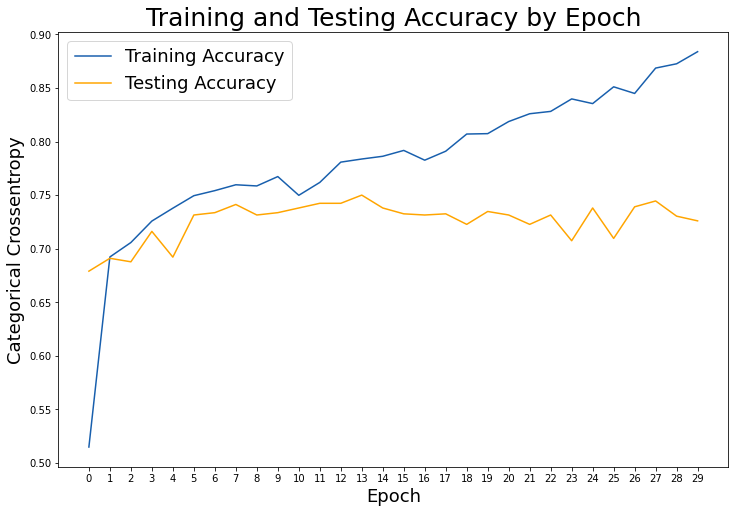

In [61]:
# Check out our train loss and test loss over epochs.
train_accuracy = history2.history['accuracy']
test_accuracy = history2.history['val_accuracy']

# Generate line plot of training, testing loss over epochs.
plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(30), np.arange(30))
plt.legend(fontsize = 18);

**As you can see from the chart above, the model begins to seriously overfit around epoch 13. Again I think I need a different approach model-wise and image augmentation-wise vice just super tuning hyperparameters.**